In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
data.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [5]:
float(data.WnvPresent.sum()) / data.count()

Date                      0.052446
Address                   0.052446
Species                   0.052446
Block                     0.052446
Street                    0.052446
Trap                      0.052446
AddressNumberAndStreet    0.052446
Latitude                  0.052446
Longitude                 0.052446
AddressAccuracy           0.052446
NumMosquitos              0.052446
WnvPresent                0.052446
dtype: float64

In [6]:
data.groupby('Species').WnvPresent.sum()

Species
CULEX ERRATICUS             0
CULEX PIPIENS             240
CULEX PIPIENS/RESTUANS    262
CULEX RESTUANS             49
CULEX SALINARIUS            0
CULEX TARSALIS              0
CULEX TERRITANS             0
Name: WnvPresent, dtype: int64

In [7]:
data.shape

(10506, 12)

In [8]:
# drop redundant columns
data = data[['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent']]

In [9]:
data.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0


In [10]:
# calculate the total number of mos for one trap each day
mos = data.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).NumMosquitos.sum()

In [11]:
mos.head(20)

Date        Species                 Trap  Latitude   Longitude 
2007-05-29  CULEX PIPIENS           T096  41.731922  -87.677512    1
            CULEX PIPIENS/RESTUANS  T002  41.954690  -87.800991    1
                                    T015  41.974089  -87.824812    1
                                    T048  41.867108  -87.654224    1
                                    T050  41.919343  -87.694259    1
                                    T054  41.921965  -87.632085    2
                                    T086  41.688324  -87.676709    1
                                    T129  41.891126  -87.611560    1
                                    T143  41.999129  -87.795585    1
                                    T148  42.017430  -87.687769    1
            CULEX RESTUANS          T002  41.954690  -87.800991    1
                                    T007  41.994991  -87.769279    1
                                    T015  41.974089  -87.824812    4
                                    T04

In [12]:
wnv = data.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).WnvPresent.sum()

In [13]:
# put number of mos and virus present back together
df = pd.concat([mos, wnv], axis=1)

In [14]:
# now all the columns we group on are indices, need to convert them back to column names
df.head()

NumMosquitos  \
Date       Species                Trap Latitude  Longitude                  
2007-05-29 CULEX PIPIENS          T096 41.731922 -87.677512             1   
           CULEX PIPIENS/RESTUANS T002 41.954690 -87.800991             1   
                                  T015 41.974089 -87.824812             1   
                                  T048 41.867108 -87.654224             1   
                                  T050 41.919343 -87.694259             1   

                                                             WnvPresent  
Date       Species                Trap Latitude  Longitude               
2007-05-29 CULEX PIPIENS          T096 41.731922 -87.677512           0  
           CULEX PIPIENS/RESTUANS T002 41.954690 -87.800991           0  
                                  T015 41.974089 -87.824812           0  
                                  T048 41.867108 -87.654224           0  
                                  T050 41.919343 -87.694259           0

In [15]:
df.reset_index(level=['Date', 'Species', 'Trap', 'Latitude', 'Longitude'], inplace=True)

In [16]:
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0


In [17]:
# we have values over 1, need to convert them back to 1
df.WnvPresent.value_counts()

0     8018
1      409
2       31
3        9
4        2
7        1
6        1
5        1
10       1
9        1
8        1
Name: WnvPresent, dtype: int64

In [18]:
df.WnvPresent = df.WnvPresent.apply(lambda x: 1 if x>=1 else 0)

In [19]:
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0


In [20]:
df.WnvPresent.value_counts()

0    8018
1     457
Name: WnvPresent, dtype: int64

In [21]:
df.shape

(8475, 7)

In [22]:
df.isnull().sum()

Date            0
Species         0
Trap            0
Latitude        0
Longitude       0
NumMosquitos    0
WnvPresent      0
dtype: int64

In [23]:
df.dtypes

Date             object
Species          object
Trap             object
Latitude        float64
Longitude       float64
NumMosquitos      int64
WnvPresent        int64
dtype: object

In [24]:
df.Date = pd.to_datetime(df.Date)

In [25]:
df.dtypes

Date            datetime64[ns]
Species                 object
Trap                    object
Latitude               float64
Longitude              float64
NumMosquitos             int64
WnvPresent               int64
dtype: object

In [26]:
weather = pd.read_csv("weather.csv")

In [27]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [28]:
weather.drop('CodeSum', axis=1, inplace=True)

In [29]:
weather.Tavg = weather.Tavg.apply(lambda x: str(x))

In [30]:
weather1 = weather[weather['Station']==1]
weather2 = weather[weather['Station']==2]
weather1 = weather1.drop('Station', axis=1)
weather2 = weather2.drop('Station', axis=1)

In [31]:
weather1.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
4,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
6,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,0,M,0.0,T,29.31,30.05,10.4,8,10.8
8,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,0,M,0.0,T,29.40,30.10,11.7,7,12.0


In [32]:
weather1 = weather[weather['Station']==1]
weather2 = weather[weather['Station']==2]
weather1 = weather1.drop('Station', axis=1)
weather2 = weather2.drop('Station', axis=1)

In [33]:
weather1.columns = weather1.columns + str(1)

In [34]:
weather1.columns

Index([u'Date1', u'Tmax1', u'Tmin1', u'Tavg1', u'Depart1', u'DewPoint1',
       u'WetBulb1', u'Heat1', u'Cool1', u'Sunrise1', u'Sunset1', u'Depth1',
       u'Water11', u'SnowFall1', u'PrecipTotal1', u'StnPressure1',
       u'SeaLevel1', u'ResultSpeed1', u'ResultDir1', u'AvgSpeed1'],
      dtype='object')

In [35]:
weather1.rename(columns={'Date1': 'Date'}, inplace=True)

In [36]:
weather2.columns = weather2.columns +str(2)

In [37]:
weather2.rename(columns={'Date2': 'Date'}, inplace=True)

In [38]:
weather = weather1.merge(weather2, on='Date')

In [39]:
weather.head()

,Date,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,WetBulb1,Heat1,Cool1,Sunrise1,...,Sunset2,Depth2,Water12,SnowFall2,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2
0,2007-05-01,83,50,67,14,51,56,0,2,0448,...,-,M,M,M,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,...,-,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,...,-,M,M,M,0.00,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,...,-,M,M,M,0.00,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,...,-,M,M,M,T,29.46,30.09,11.2,7,11.5


In [40]:
weather.Date = pd.to_datetime(weather.Date)

In [41]:
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [43]:
weather.dtypes

Date            datetime64[ns]
Tmax1                    int64
Tmin1                    int64
Tavg1                   object
Depart1                 object
DewPoint1                int64
WetBulb1                object
Heat1                   object
Cool1                   object
Sunrise1                object
Sunset1                 object
Depth1                  object
Water11                  int64
SnowFall1               object
PrecipTotal1            object
StnPressure1            object
SeaLevel1               object
ResultSpeed1           float64
ResultDir1               int64
AvgSpeed1               object
Tmax2                    int64
Tmin2                    int64
Tavg2                   object
Depart2                  int64
DewPoint2                int64
WetBulb2                object
Heat2                   object
Cool2                   object
Sunrise2                 int64
Sunset2                  int64
Depth2                   int64
Water12                  int64
SnowFall

In [44]:
df = pd.merge(df, weather, on='Date', how='left')

In [45]:
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax1,Tmin1,Tavg1,...,Sunset2,Depth2,Water12,SnowFall2,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,88,60,74,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,88,60,74,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,88,60,74,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,88,60,74,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,88,60,74,...,-1,-1,-1,-1,0.00,29.44,30.09,5.8,16,7.4


In [46]:
df.isnull().sum()

Date            0
Species         0
Trap            0
Latitude        0
Longitude       0
NumMosquitos    0
WnvPresent      0
Tmax1           0
Tmin1           0
Tavg1           0
Depart1         0
DewPoint1       0
WetBulb1        0
Heat1           0
Cool1           0
Sunrise1        0
Sunset1         0
Depth1          0
Water11         0
SnowFall1       0
PrecipTotal1    0
StnPressure1    0
SeaLevel1       0
ResultSpeed1    0
ResultDir1      0
AvgSpeed1       0
Tmax2           0
Tmin2           0
Tavg2           0
Depart2         0
DewPoint2       0
WetBulb2        0
Heat2           0
Cool2           0
Sunrise2        0
Sunset2         0
Depth2          0
Water12         0
SnowFall2       0
PrecipTotal2    0
StnPressure2    0
SeaLevel2       0
ResultSpeed2    0
ResultDir2      0
AvgSpeed2       0
dtype: int64

In [47]:
df.shape

(8475, 45)

In [48]:
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Week'] = df.Date.dt.week
df['Day'] = df.Date.dt.day

In [49]:
spray = pd.read_csv("spray.csv")

In [50]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [51]:
print spray.Date.nunique()
print spray.Date.unique()

10
['2011-08-29' '2011-09-07' '2013-07-17' '2013-07-25' '2013-08-08'
 '2013-08-15' '2013-08-16' '2013-08-22' '2013-08-29' '2013-09-05']


In [52]:
print df.Date.nunique()
print df.Date.unique()

95
['2007-05-29T00:00:00.000000000' '2007-06-05T00:00:00.000000000'
 '2007-06-26T00:00:00.000000000' '2007-06-29T00:00:00.000000000'
 '2007-07-02T00:00:00.000000000' '2007-07-11T00:00:00.000000000'
 '2007-07-18T00:00:00.000000000' '2007-07-19T00:00:00.000000000'
 '2007-07-25T00:00:00.000000000' '2007-07-27T00:00:00.000000000'
 '2007-08-01T00:00:00.000000000' '2007-08-02T00:00:00.000000000'
 '2007-08-03T00:00:00.000000000' '2007-08-07T00:00:00.000000000'
 '2007-08-08T00:00:00.000000000' '2007-08-09T00:00:00.000000000'
 '2007-08-15T00:00:00.000000000' '2007-08-16T00:00:00.000000000'
 '2007-08-17T00:00:00.000000000' '2007-08-21T00:00:00.000000000'
 '2007-08-22T00:00:00.000000000' '2007-08-24T00:00:00.000000000'
 '2007-08-28T00:00:00.000000000' '2007-09-04T00:00:00.000000000'
 '2007-09-05T00:00:00.000000000' '2007-09-06T00:00:00.000000000'
 '2007-09-12T00:00:00.000000000' '2007-09-18T00:00:00.000000000'
 '2007-09-19T00:00:00.000000000' '2007-09-24T00:00:00.000000000'
 '2007-09-25T00:00:00.

In [53]:
df['merge_latitude'] = df.Latitude.apply(lambda x: round(x, 2))

In [54]:
df['merge_longitude'] = df.Longitude.apply(lambda x: round(x, 2))

In [55]:
spray['merge_latitude'] = spray.Latitude.apply(lambda x: round(x, 2))
spray['merge_longitude'] = spray.Longitude.apply(lambda x: round(x, 2))

In [56]:
spray.Date = pd.to_datetime(spray.Date)

In [57]:
spray['Year'] = spray.Date.dt.year
spray['Week'] = spray.Date.dt.week

In [58]:
spray['Spray1'] = 1

In [59]:
spray.drop('Time', axis=1, inplace=True)

In [60]:
spray = spray.iloc[:, 3:]

In [61]:
spray.head()

,merge_latitude,merge_longitude,Year,Week,Spray1
0,42.39,-88.09,2011,35,1
1,42.39,-88.09,2011,35,1
2,42.39,-88.09,2011,35,1
3,42.39,-88.09,2011,35,1
4,42.39,-88.09,2011,35,1


In [62]:
spray['Week2'] = spray.Week + 1
spray['Week3'] = spray.Week + 2
spray['Spray2'] = 1
spray['Spray3'] = 1
spray.head()

,merge_latitude,merge_longitude,Year,Week,Spray1,Week2,Week3,Spray2,Spray3
0,42.39,-88.09,2011,35,1,36,37,1,1
1,42.39,-88.09,2011,35,1,36,37,1,1
2,42.39,-88.09,2011,35,1,36,37,1,1
3,42.39,-88.09,2011,35,1,36,37,1,1
4,42.39,-88.09,2011,35,1,36,37,1,1


In [63]:
spray.drop_duplicates(keep='first', inplace=True)

In [64]:
spray_week1 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week', 'Spray1']]

In [65]:
spray_week2 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week2', 'Spray2']]
spray_week2.rename(columns={'Week2':'Week'}, inplace=True)

/Users/guaisang/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [66]:
spray_week3 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week3', 'Spray3']]
spray_week3.rename(columns={'Week3':'Week'}, inplace=True)

In [67]:
df = pd.merge(df, spray_week1, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [68]:
df = pd.merge(df, spray_week2, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [69]:
df = pd.merge(df, spray_week3, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [70]:
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax1,Tmin1,Tavg1,...,AvgSpeed2,Year,Month,Week,Day,merge_latitude,merge_longitude,Spray1,Spray2,Spray3
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,88,60,74,...,7.4,2007,5,22,29,41.73,-87.68,NaN,NaN,NaN
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,88,60,74,...,7.4,2007,5,22,29,41.95,-87.80,NaN,NaN,NaN
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,88,60,74,...,7.4,2007,5,22,29,41.97,-87.82,NaN,NaN,NaN
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,88,60,74,...,7.4,2007,5,22,29,41.87,-87.65,NaN,NaN,NaN
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,88,60,74,...,7.4,2007,5,22,29,41.92,-87.69,NaN,NaN,NaN


In [71]:
# Get rid of NaNs. Replace them with 0s.
df.Spray1 = df.Spray1.apply(lambda x: 1 if x == 1 else 0)
df.Spray2 = df.Spray2.apply(lambda x: 1 if x == 1 else 0)
df.Spray3 = df.Spray3.apply(lambda x: 1 if x == 1 else 0)

In [72]:
df['Sprayed'] = df.Spray1 + df.Spray2 + df.Spray3

In [73]:
df.shape

(8475, 55)

In [74]:
df.Sprayed.sum()

116

In [75]:
df.drop(['merge_latitude', 'merge_longitude', 'Spray1', 'Spray2', 'Spray3'], axis=1, inplace=True)
df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax1,Tmin1,Tavg1,...,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Month,Week,Day,Sprayed
0,2007-05-29,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0
2,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0
4,2007-05-29,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,88,60,74,...,29.44,30.09,5.8,16,7.4,2007,5,22,29,0


In [76]:
df.Sprayed.value_counts()

0    8359
1     116
Name: Sprayed, dtype: int64

In [77]:
116 / 2012.

0.05765407554671968

In [78]:
df.Year.value_counts()

2007    2775
2013    2012
2009    1915
2011    1773
Name: Year, dtype: int64

In [79]:
df.drop(['Date', 'Month', 'Day'], axis=1, inplace=True)

In [80]:
df['wnv'] = df.WnvPresent

In [81]:
df.drop('WnvPresent', axis=1, inplace=True)

In [82]:
df.head()

,Species,Trap,Latitude,Longitude,NumMosquitos,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,CULEX PIPIENS,T096,41.731922,-87.677512,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
1,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
2,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
3,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0
4,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,88,60,74,10,58,...,0.00,29.44,30.09,5.8,16,7.4,2007,22,0,0


In [83]:
df.to_csv('~/desktop/wnv.csv')

### Done with cleaning.

In [84]:
df = pd.read_csv('~/desktop/wnv.csv')

In [85]:
df.head()

,Unnamed: 0,Species,Trap,Latitude,Longitude,NumMosquitos,Tmax1,Tmin1,Tavg1,Depart1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,0,CULEX PIPIENS,T096,41.731922,-87.677512,1,88,60,74,10,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
1,1,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,88,60,74,10,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
2,2,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,88,60,74,10,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
3,3,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,88,60,74,10,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
4,4,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,88,60,74,10,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0


In [86]:
df.drop(['Unnamed: 0', 'NumMosquitos'], axis=1, inplace=True)

In [87]:
df.head()

,Species,Trap,Latitude,Longitude,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,WetBulb1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,CULEX PIPIENS,T096,41.731922,-87.677512,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
1,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
2,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
3,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
4,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0


In [88]:
le = LabelEncoder()
cols = [i for i in df.select_dtypes(include=['object']).columns]
df[cols] = df[cols].apply(le.fit_transform)

In [89]:
1-float(df.wnv.sum())/len(df.wnv)

0.9460766961651917

In [90]:
df.dtypes

Species           int64
Trap              int64
Latitude        float64
Longitude       float64
Tmax1             int64
Tmin1             int64
Tavg1             int64
Depart1           int64
DewPoint1         int64
WetBulb1          int64
Heat1             int64
Cool1             int64
Sunrise1          int64
Sunset1           int64
Depth1            int64
Water11           int64
SnowFall1       float64
PrecipTotal1    float64
StnPressure1    float64
SeaLevel1       float64
ResultSpeed1    float64
ResultDir1        int64
AvgSpeed1       float64
Tmax2             int64
Tmin2             int64
Tavg2             int64
Depart2           int64
DewPoint2         int64
WetBulb2          int64
Heat2             int64
Cool2             int64
Sunrise2          int64
Sunset2           int64
Depth2            int64
Water12           int64
SnowFall2         int64
PrecipTotal2    float64
StnPressure2    float64
SeaLevel2       float64
ResultSpeed2    float64
ResultDir2        int64
AvgSpeed2       

In [91]:
df.head()

,Species,Trap,Latitude,Longitude,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,WetBulb1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,1,74,41.731922,-87.677512,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
1,2,1,41.954690,-87.800991,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
2,2,13,41.974089,-87.824812,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
3,2,35,41.867108,-87.654224,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0
4,2,37,41.919343,-87.694259,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,22,0,0


In [92]:
X = df.iloc[:,0:-1]
y = df.wnv

### Feature Selection

In [93]:
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
Trap,0.232859
Longitude,0.218178
Latitude,0.204502
Species,0.164382
Sunrise1,0.021973
Week,0.014513
Sprayed,0.008682
AvgSpeed1,0.008597
Sunset1,0.008380
ResultDir2,0.007796


In [154]:
X = df[['Longitude', 'Latitude', 'Trap', 'Species', 'Sunrise1', 'Week']]

### Try Ramdom Forest

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.wnv, random_state=42)

In [155]:
rf_params = {'n_estimators': [5, 10, 15, 20, 30], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None],
            'max_depth': [3, 5, 10, None]}
rfgs = GridSearchCV(rf, rf_params, scoring='roc_auc')
rfgs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 30], 'max_features': ['auto', 'sqrt', 'log2', None], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 10, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [156]:
rfgs.score(X_test, y_test)

0.81163271868989328

In [157]:
print rfgs.best_params_

{'max_features': None, 'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 5}


In [158]:
print rfgs.best_score_

0.812545399811


In [159]:
rf = RandomForestClassifier(max_features=None, n_estimators=20, criterion='entropy', max_depth=5)

In [160]:
print cross_val_score(rf, X, y, cv=5, n_jobs=-1).mean()
rf_pred = cross_val_predict(rf, X, y, cv=5, n_jobs=-1)

0.917859722278


In [161]:
conmat = np.array(confusion_matrix(y, rf_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
confusion

,pred wnv,pred no wnv
wnv,0,457
no wnv,239,7779


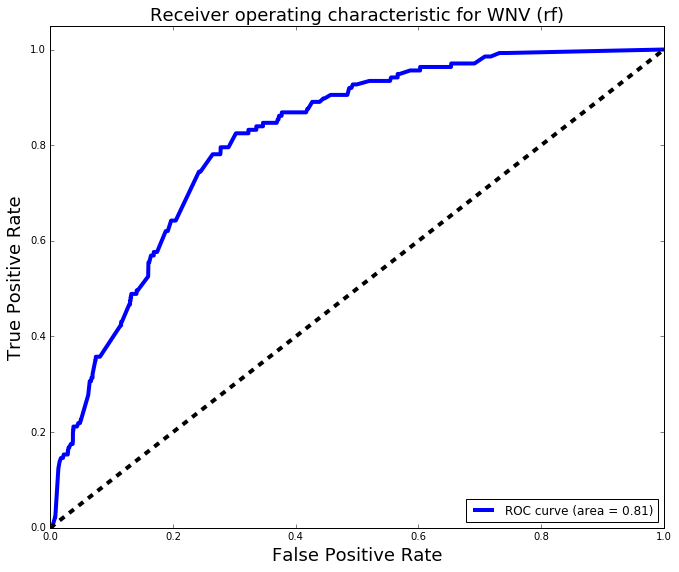

In [162]:
rf.fit(X_train, y_train)
rf_prob = rf.predict_proba(X_test)[:,1]
rffpr = dict()
rftpr = dict()
rfroc_auc=dict()
rffpr[1], rftpr[1], _ = roc_curve(y_test, rf_prob)
rfroc_auc[1] = auc(rffpr[1], rftpr[1])
plt.figure(figsize=[11,9])
plt.plot(rffpr[1], rftpr[1], label='ROC curve (area = %0.2f)' % rfroc_auc[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV (rf)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Try SVM

In [99]:
numerical_features = ['Longitude', 'Latitude', 'Sunrise1', 'Week']
for i in numerical_features:
    df[i] = (df[i]-df[i].mean())/df[i].std()

In [100]:
df.head()

,Species,Trap,Latitude,Longitude,Tmax1,Tmin1,Tavg1,Depart1,DewPoint1,WetBulb1,...,PrecipTotal2,StnPressure2,SeaLevel2,ResultSpeed2,ResultDir2,AvgSpeed2,Year,Week,Sprayed,wnv
0,1,74,-1.057091,0.205515,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0
1,2,1,1.032481,-1.263375,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0
2,2,13,1.214444,-1.546746,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0
3,2,35,0.210958,0.482546,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0
4,2,37,0.700924,0.006295,88,60,74,10,58,65,...,0.0,29.44,30.09,5.8,16,7.4,2007,-2.064499,0,0


In [102]:
X = df[['Longitude', 'Latitude', 'Trap', 'Species', 'Sunrise1', 'Week']]
enc = OneHotEncoder(categorical_features=[2,3])
X = enc.fit_transform(X)

In [136]:
clf = svm.SVC(kernel='rbf')
clf_params = {'C': 10.**np.arange(-2,3), 'gamma': 10.**np.arange(-5,2)}
clfgs = GridSearchCV(clf, clf_params, scoring='roc_auc')
clfgs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [137]:
clfgs.score(X_test, y_test)

0.76359891026691185

In [138]:
print clfgs.best_params_
print clfgs.best_score_

{'C': 100.0, 'gamma': 0.0001}
0.769159130406


In [139]:
from sklearn.cross_validation import StratifiedKFold
cv = StratifiedKFold(df.wnv, n_folds=5, shuffle=True, random_state=7)

In [146]:
clf = svm.SVC(kernel='rbf', C=100, gamma=0.0001, probability=True)
clfscore = cross_val_score(clf, X, y, cv=cv, n_jobs=-1).mean()
clf_pred = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)
print clfscore

0.94607682036


In [147]:
cm_clf = np.array(confusion_matrix(y, clf_pred, labels=[1,0]))
confusion_clf = pd.DataFrame(cm_clf, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
confusion_clf

,pred wnv,pred no wnv
wnv,0,457
no wnv,0,8018


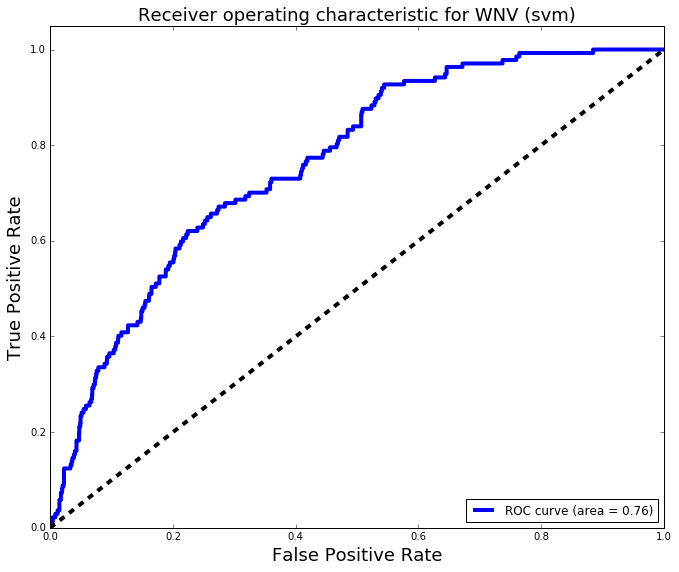

In [148]:
clf.fit(X_train, y_train)
clf_prob = clf.predict_proba(X_test)[:,1]
clffpr = dict()
clftpr = dict()
clfroc_auc=dict()
clffpr[1], clftpr[1], _ = roc_curve(y_test, clf_prob)
clfroc_auc[1] = auc(clffpr[1], clftpr[1])
plt.figure(figsize=[11,9])
plt.plot(clffpr[1], clftpr[1], label='ROC curve (area = %0.2f)' % clfroc_auc[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV (svm)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Try Neural Network (Great ROC curve. We are going to win!)

In [115]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Using Theano backend.


In [116]:
xs = X.astype(float).toarray()
ys = np_utils.to_categorical(y)

In [117]:
ys.shape

(8475, 2)

In [118]:
xs.shape

(8475, 147)

In [122]:
def baseline_model():
    model = Sequential()
    model.add(Dense(147, input_dim=147, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(147, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [123]:
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=2, batch_size=50, verbose=0)

In [124]:
nnscore = cross_val_score(estimator, xs, ys, cv=cv).mean()
print nnscore

0.946076819973


In [125]:
nn_pred = cross_val_predict(estimator, xs, ys, cv=cv)

In [126]:
cm_nn = np.array(confusion_matrix(y, nn_pred, labels=[1,0]))
confusion_nn = pd.DataFrame(cm_nn, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
confusion_nn

,pred wnv,pred no wnv
wnv,0,457
no wnv,0,8018


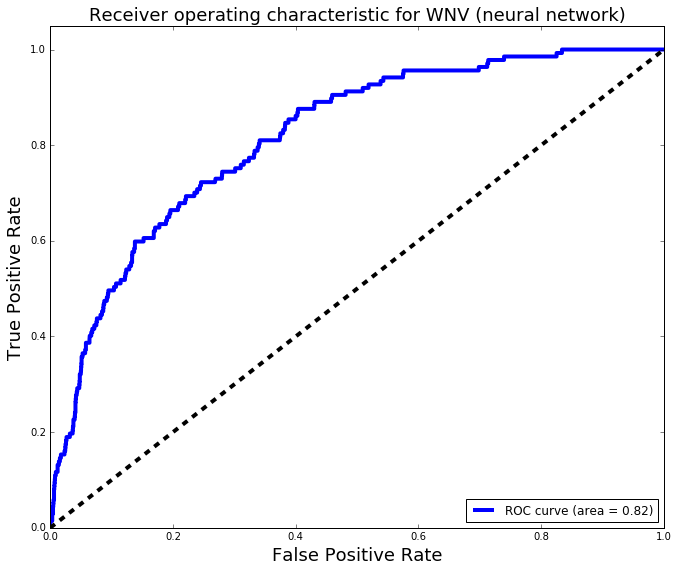

In [127]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.3, stratify=df.wnv, random_state=42)
estimator.fit(xs_train, ys_train)
nn_prob = estimator.predict_proba(xs_test)[:,1]
nnfpr = dict()
nntpr = dict()
nnroc_auc=dict()
nnfpr[1], nntpr[1], _ = roc_curve(y_test, nn_prob)
nnroc_auc[1] = auc(nnfpr[1], nntpr[1])
plt.figure(figsize=[11,9])
plt.plot(nnfpr[1], nntpr[1], label='ROC curve (area = %0.2f)' % nnroc_auc[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV (neural network)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [121]:
import seaborn as sns

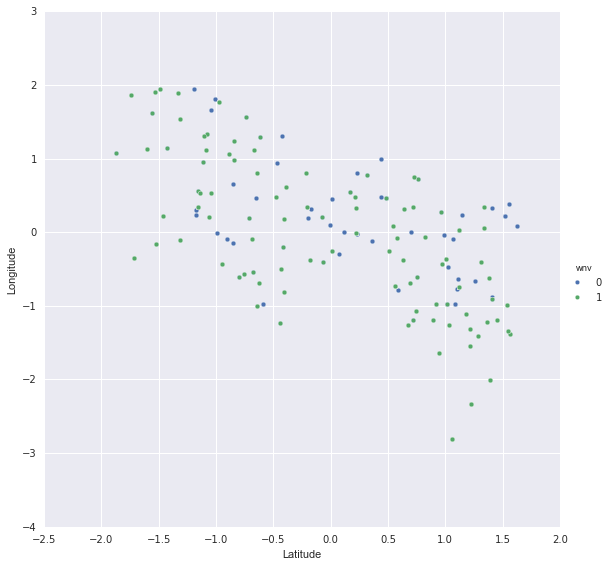

In [127]:
sns.set()
sns.pairplot(df, x_vars='Latitude', y_vars='Longitude', hue='wnv', size=8)